In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import json
import collections
import re
from pathlib import Path

# Plotting functions

In [166]:
def get_relevant_info(config):
    try:
        model = config['model']
    except KeyError:
        try:
            d = config['save_new']
        except KeyError:
            raise ValueError("Could not find model and legnthscale")
        return dict(model=d['model'], internal_lengthscale=d['internal_lengthscale']) 
    try:
        internal_lengthscale=config['internal_lengthscale']
    except KeyError:
        internal_lengthscale=None
    
    return dict(model=model, internal_lengthscale=internal_lengthscale)

def build_data(base_path, model_name=None, test_name=None, skip_incomplete=True, required_index=None):       
    output = {}
    test_output = {}
    
    base_path = Path(base_path)
    for run_dir in os.listdir(base_path):
        try:
            with open(base_path/run_dir/"old_config.json") as f:
                config = json.load(f)
        except FileNotFoundError:
            print(f"Skipping {run_dir}, old_config not found ")
            continue
        
        relevant = get_relevant_info(config)
        
        if model_name is None:
            model_name = relevant['model']
            print(f"The model name is {model_name}")
        else:
            if relevant['model'] != model_name:
                print(f"Skipping {run_dir}, uses model={relevant['model']} instead of model={model_name}")
                continue
        
        #except KeyError:
        #    # Go to the experiment this was using
        #    new = ExperimentResults(f"{ExperimentResults(p, '').host}:{config['kernel_matrix_path']}", "")
        #    with new.open("config.json") as f:
        #        a = json.load(f)
                
        if relevant["internal_lengthscale"] is not None:
            if abs(relevant["internal_lengthscale"] - 3.758374) < 1e-6:
                relevant["internal_lengthscale"] = 3.758374  # Prevent separation of various lscales
                
        raw_cv_acc = pd.read_pickle(base_path/run_dir/"n_splits_4"/"grid_acc.pkl.gz")
        cv_acc = raw_cv_acc.drop(10, axis="columns").dropna()
        if len(raw_cv_acc) != len(cv_acc):
            print(f"Dropped {len(raw_cv_acc)-len(cv_acc)} rows from {run_dir}")
            if skip_incomplete:
                print("Skipping...")
                continue
                
        if required_index is None:
            required_index = np.copy(cv_acc.index)
        else:
            if not np.array_equal(cv_acc.index, required_index):
                print(f"Index for {run_dir} is {cv_acc.index}, different from {required_index}. Continuing...")
                cv_acc = cv_acc.loc[required_index, :]
                #continue
        
        if relevant['internal_lengthscale'] not in output:
            output[relevant['internal_lengthscale']] = pd.DataFrame(index=required_index, columns=[])
        out_df = output[relevant['internal_lengthscale']]

        print(f"Processing {run_dir}")
        cv_acc = cv_acc.applymap(lambda x: np.max(x[1], axis=-1))
        for col in cv_acc.columns:
            if col not in out_df.columns:
                out_df = pd.concat([out_df, cv_acc[col]], axis='columns', verify_integrity=True)
            else:
                for row in required_index:
                    out_df.loc[row, col] = np.concatenate([out_df.loc[row, col], cv_acc.loc[row, col]], axis=0)
                    
        raw_test_acc = pd.read_pickle(base_path/run_dir/"n_splits_4"/"accuracy.pkl.gz")
        if test_name is None:  # Print values to tell which it is
            print(collections.Counter(raw_test_acc.loc[0, 1280][1]))
            test_df = None
        elif run_dir == test_name:
            test_acc = raw_test_acc.drop(10, axis="columns").dropna().applymap(lambda a: a[1])
            if not np.array_equal(test_acc.index, cv_acc.index):
                test_acc = test_acc.loc[required_index]
            print(f"Found test run_dir: {test_name}")
            test_output[relevant['internal_lengthscale']] = (cv_acc, test_acc)
                    
        output[relevant['internal_lengthscale']] = out_df

    return output, test_output

def test_data_to_plottable(test_data):
    out = {}
    out_test = {}
    for ls in test_data.keys():
        df, test_df = test_data[ls]
        out_series = pd.Series()
        # Reduce taking the maximum over top-level layers
        for col in df.columns:
            val = df.loc[df.index[0], col]
            for row in df.index[1:]:
                val = np.maximum(val, df.loc[row, col])
            out_series.loc[col] = val
        out[ls] = out_series
        
        if test_df is not None:
            test_series = pd.Series()
            for col in df.columns:
                test_val = np.zeros_like(df.loc[df.index[0], col])
                # For supplementary material: Find which is the final layer lengthscale with maximum 
                for row in df.index:
                    maximum_is_here_mask = (df.loc[row, col] == out_series.loc[col])
                    test_val[maximum_is_here_mask] = test_df.loc[row, col][maximum_is_here_mask]
                test_series.loc[col] = test_val
            out_test[ls] = test_series
    return out, out_test




def cv_data_to_plottable(cv_data):
    out = {}
    out_test = {}
    for ls in cv_data.keys():
        df = cv_data[ls]
        out_series = pd.Series()
        argmax = df.applymap(np.mean).idxmax()
        for col in df.columns:
            #val = df.loc[df.index[0], col]
            #for row in df.index[1:]:
            #    val = np.maximum(val, df.loc[row, col])
            val = df.loc[argmax[col], col]
            out_series.loc[col] = val
        out[ls] = out_series
    return out

def plottable_sweep(means, vars, Ns):
    df = pd.DataFrame(columns=[2**i * 10 for i in range(9)])
    df_e = pd.DataFrame(columns=[2**i * 10 for i in range(9)])
    for ls in means.keys():
        m, e = _one_plottable_sweep(means[ls], vars[ls], Ns[ls])
        # ignore e TODO stop ignoring it
        #arg = m.idxmax(axis=0).loc[1280]
        print(m.index)
        #acc_max = m.max(axis=0)
        acc_max = m.loc[arg, :]
        err_max = e.loc[arg, :]
        #acc_max = m.iloc[-1, :]
        #err_max = e.iloc[-1, :]
        if ls is None:
            ls = -10
        df.loc[ls, :] = acc_max
        df_e.loc[ls, :] = err_max
    return df.sort_index(), df_e.sort_index()

def plottable_to_mean_err(plottable):
    mean = plottable.applymap(np.mean)
    err = plottable.applymap(lambda a: np.std(a, ddof=1)*(2/np.sqrt(len(a))))
    return mean, err


# RBFMyrtle processing

In [153]:
outputs, test_outputs = build_data("/scratch/ag919/logs/final_figures/M10-RBF/fig/rbfmyrtle_v3",
                                   test_name="poisson_20")

The model name is RBFMyrtle_v3
Processing poisson_26
Processing poisson_40
Processing poisson_33
Processing 19
Processing poisson_42
Processing poisson_22
Processing poisson_28
Processing poisson_25
Processing 16
Processing 18
Processing poisson_39
Processing poisson_20
Found test run_dir: poisson_20
Processing poisson_36
Processing poisson_29
Processing 15
Processing poisson_37
Processing poisson_38
Processing poisson_41
Processing 20
Processing poisson_31
Processing poisson_24
Processing 21
Processing poisson_23
Processing 22
Processing 24
Processing poisson_35
Processing poisson_34
Processing poisson_30
Processing 17
Processing 14
Processing poisson_21
Processing 23
Processing poisson_32


In [69]:
outputs2, test_outputs2 = build_data("/scratch/ag919/logs/final_figures/M10-RBF/fig/rbfmyrtle_v3",
                                   model_name="RBFMyrtle_v3_tight",
                                   test_name="poisson_20")

Skipping poisson_26, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping poisson_40, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping poisson_33, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping 19, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping poisson_42, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping poisson_22, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping poisson_28, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping poisson_25, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping 16, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping 18, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping poisson_39, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping poisson_20, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping poisson_36, uses model=RBFMyrtle_v3 instead

In [164]:
outputs[1.045].applymap(np.mean).idxmax()

20      26
40      26
80      26
160     13
320     26
640     26
1280    15
dtype: int64

In [167]:
dict_plottable = cv_data_to_plottable(outputs)
v = dict_plottable[None]  # None means 0 lengthscale, because it's independent
del dict_plottable[None]
dict_plottable[0.0] = v
plottable = pd.DataFrame(dict_plottable)
mean, err = plottable_to_mean_err(plottable)

mean = mean.T.sort_index()
err = err.T.sort_index()

pd.to_pickle((mean, err), "~/Programacio/cnn-limits/figures/m10_rbf_cv.pkl.gz")

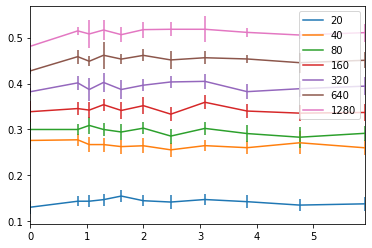

In [168]:
mean.plot(yerr=err)

In [169]:
dict_plottable = cv_data_to_plottable(outputs2)
#v = dict_plottable[None]  # None means 0 lengthscale, because it's independent
#del dict_plottable[None]
#dict_plottable[0.0] = v
plottable = pd.DataFrame(dict_plottable)
mean2, err2 = plottable_to_mean_err(plottable)

mean2 = mean2.T.sort_index()
err2 = err2.T.sort_index()

#pd.to_pickle((mean, err), "~/Programacio/cnn-limits/figures/m10_rbf_cv.pkl.gz")

/homes/ag919/venv/py37/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/homes/ag919/venv/py37/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/homes/ag919/venv/py37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


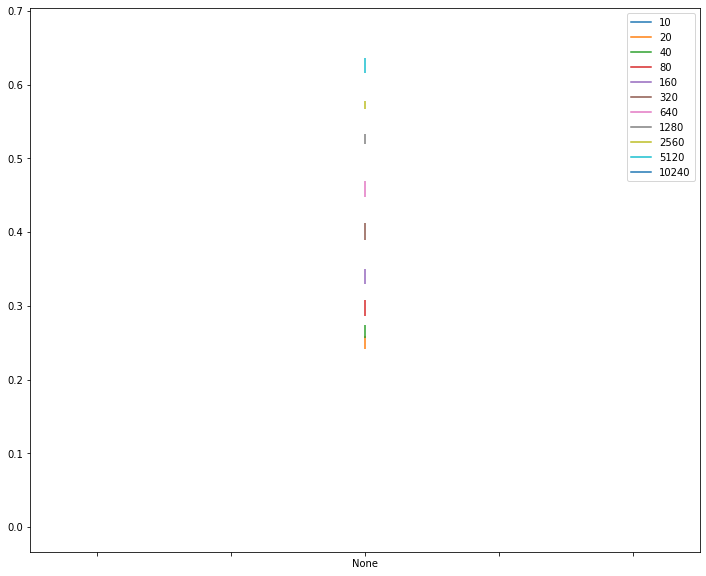

In [170]:
_, ax = plt.subplots(1, 1, figsize=(12, 10))
#mean.plot(yerr=err, ax=ax)
mean2.plot(yerr=err2, ax=ax)

In [72]:
cv_for_test_data, test_data = test_data_to_plottable(test_outputs)
a = {}
for name, dict_plottable in (("cv", cv_for_test_data), ("test", test_data)):
    plottable = pd.DataFrame(dict_plottable)
    mean, err = plottable_to_mean_err(plottable)
    mean = mean.T.sort_index()
    err = err.T.sort_index()
    a[name] = (mean, err)

pd.to_pickle(a, "~/Programacio/cnn-limits/figures/m10_rbf_test.pkl.gz")

/homes/ag919/venv/py37/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/homes/ag919/venv/py37/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [73]:
a["test"][0]

,10,20,40,80,160,320,640,1280
5.912,0.167763,0.201289,0.230522,0.269981,0.325762,0.391,0.44195,0.4963


# Matern Myrtle processing

In [171]:
outputs, test_outputs = build_data("/scratch/ag919/logs/final_figures/M10-Matern/fig/rbfmyrtle_v3")

Skipping 1, old_config not found 
Skipping 40, old_config not found 
The model name is Myrtle10_replaced_tick_v3_sweep
Processing 35
Counter({1.0: 1})
Processing 4
Counter({0.0: 1})
Processing 19
Counter({0.0: 1})
Processing 9
Counter({0.0: 1})
Processing 37
Counter({0.0: 1})
Processing 28
Counter({1.0: 1})
Processing 16
Counter({0.0: 1})
Processing 6
Counter({1.0: 1})
Processing 18
Counter({1.0: 1})
Processing 3
Counter({0.0: 1})
Processing 33
Counter({1.0: 1})
Processing 43
Counter({0.0: 1})
Processing 38
Counter({0.0: 1})
Processing 15
Counter({0.0: 1})
Processing 32
Counter({0.0: 1})
Processing 13
Counter({0.0: 1})
Processing 29
Counter({0.0: 1})
Skipping _sources, old_config not found 
Processing 31
Counter({0.0: 1})
Processing 20
Counter({0.0: 1})
Processing 10
Counter({0.0: 1})
Processing 30
Counter({0.0: 1})
Processing 11
Counter({0.0: 1})
Processing 7
Counter({1.0: 1})
Processing 44
Counter({0.0: 1})
Processing 36
Counter({0.0: 1})
Processing 39
Counter({0.0: 1})
Processing 21

In [172]:
dict_plottable = cv_data_to_plottable(outputs)
if None in dict_plottable:
    v = dict_plottable[None]  # None means 0 lengthscale, because it's independent
    del dict_plottable[None]
    dict_plottable[0.0] = v
plottable = pd.DataFrame(dict_plottable)
mean = plottable.applymap(np.mean)
mean, err = plottable_to_mean_err(plottable)

mean = mean.T.sort_index()
err = err.T.sort_index()

pd.to_pickle((mean, err), "~/Programacio/cnn-limits/figures/m10_matern_cv.pkl.gz")

/homes/ag919/venv/py37/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/homes/ag919/venv/py37/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


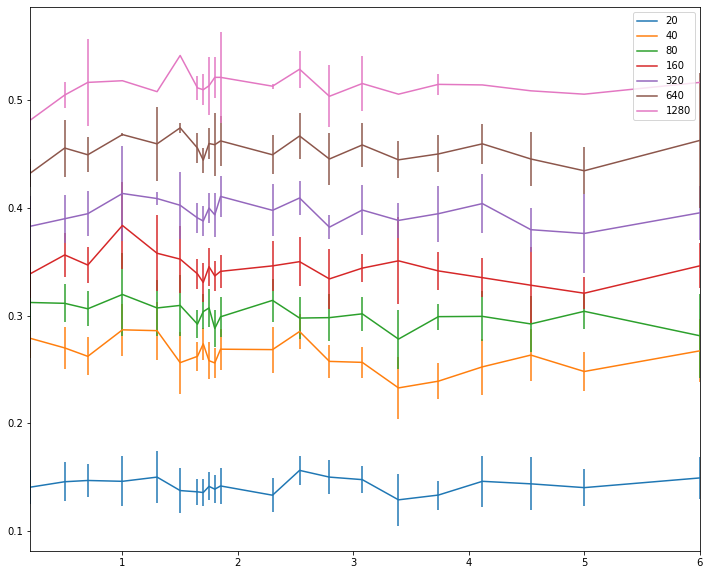

In [173]:
mean.plot(yerr=err, figsize=(12, 10))

# CNTK14 processing

In [180]:
outputs, test_outputs = build_data("/scratch/ag919/logs/final_figures/CNTK14/fig/rbfmyrtle_v3",
                                   test_name="cartwright_3")


The model name is CNTK14_sweep
Processing 1
Processing 4
Processing cartwright_3
Found test run_dir: cartwright_3
Processing 9
Processing 6
Processing 3
Skipping 15, old_config not found 
Processing 13
Skipping _sources, old_config not found 
Skipping 10, old_config not found 
Processing 11
Processing 7
Processing 2
Processing 12
Processing 14
Processing poisson_8
Processing 5
Processing 8


In [99]:
outputs2, test_outputs2 = build_data("/scratch/ag919/logs/final_figures/CNTK14/fig/AAA", test_name="110", skip_incomplete=False)

The model name is CNTK14_sweep_fewer_lengthscales
Dropped 22 rows from 110
Processing 110
Found test run_dir: 110


In [181]:
assert tuple(outputs.keys()) == (None,)
plottable = outputs[None]
mean, err = plottable_to_mean_err(plottable)

mean = mean.sort_index()
err = err.sort_index()

#pd.to_pickle((mean, err), "~/Programacio/cnn-limits/figures/cntk14_cv.pkl.gz")

/homes/ag919/venv/py37/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/homes/ag919/venv/py37/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [182]:
mean.idxmax()

20       22
40       18
80       22
160      24
320      20
640      15
1280     13
2560     13
5120     13
10240    13
dtype: int64

In [174]:
#outputs, test_outputs = build_data("/scratch/ag919/logs/final_figures/CNTK14/fig",
#                                   test_name="cartwright_bugfix_6", skip_incomplete=False)
outputs, test_outputs = build_data("/scratch/ag919/logs/final_figures/CNTK14/new_protocol",
                                   test_name="142", skip_incomplete=False)

assert tuple(test_outputs.keys()) == (None,)
cv_for_test_data, test_data = test_outputs[None]

a = {}
for name, dict_plottable in (("cv", cv_for_test_data), ("test", test_data)):
    plottable = pd.DataFrame(dict_plottable)
    mean, err = plottable_to_mean_err(plottable)
    mean = mean.sort_index()
    err = err.sort_index()
    a[name] = (mean, err)

pd.to_pickle(a, "~/Programacio/cnn-limits/figures/cntk14_3cv_experimental.pkl.gz")

The model name is CNTK14_sweep
Processing 142
Found test run_dir: 142


/homes/ag919/venv/py37/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/homes/ag919/venv/py37/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


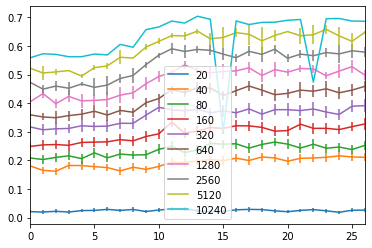

In [175]:
a["test"][0].plot(yerr=a["test"][1])

In [55]:
outputs, test_outputs = build_data("/scratch/ag919/logs/final_figures/CNTK14-2/",
                                   test_name="156", skip_incomplete=False)

assert tuple(test_outputs.keys()) == (None,)
cv_for_test_data, test_data = test_outputs[None]

a = {}
for name, dict_plottable in (("cv", cv_for_test_data), ("test", test_data)):
    plottable = pd.DataFrame(dict_plottable)
    mean, err = plottable_to_mean_err(plottable)
    mean = mean.sort_index()
    err = err.sort_index()
    a[name] = (mean, err)

def save_(slice_, name):
    (cv_m, cv_e), (t_m, t_e) = a["cv"], a["test"]
    out = dict(cv=(cv_m[slice_], cv_e[slice_]), test=(t_m[slice_], t_e[slice_]))
    pd.to_pickle(out, f"~/Programacio/cnn-limits/figures/cnngp_v2/{name}")
    
save_(slice(0, None, 6), "nngp_5.pkl.gz")
save_(slice(1, None, 6), "ntk_5.pkl.gz")
save_(slice(2, None, 6), "nngp_8.pkl.gz")
save_(slice(3, None, 6), "ntk_8.pkl.gz")
save_(slice(4, None, 6), "nngp_14.pkl.gz")
save_(slice(5, None, 6), "ntk_14.pkl.gz")
    
#pd.to_pickle(a, "~/Programacio/cnn-limits/figures/cntk14_3cv_experimental.pkl.gz")

The model name is CNTK14_split_cpu
Processing 156
Found test run_dir: 156


/homes/ag919/venv/py37/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/homes/ag919/venv/py37/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


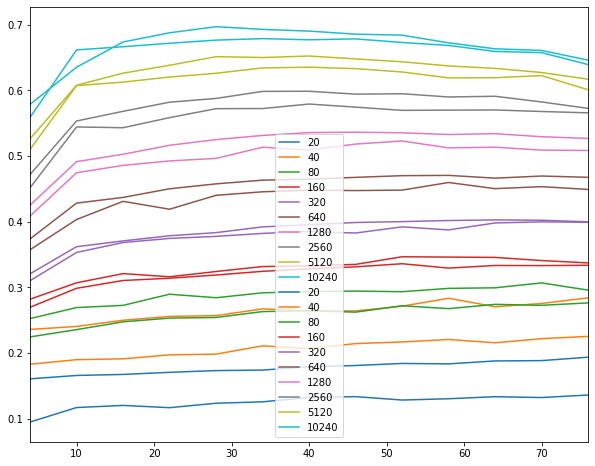

In [64]:
_, ax = plt.subplots(1, 1, figsize=(10, 8))
a["cv"][0][4::6].plot(ax=ax)
a["test"][0][4::6].plot(ax=ax)

In [106]:
assert tuple(test_outputs2.keys()) == (None,)
cv_for_test_data, test_data = test_outputs2[None]

a = {}
for name, dict_plottable in (("cv", cv_for_test_data), ("test", test_data)):
    plottable = pd.DataFrame(dict_plottable)
    mean, err = plottable_to_mean_err(plottable)
    mean = mean.sort_index()
    err = err.sort_index()
    a[name] = (mean, err)

In [ ]:
c = pd.read_pickle("/scratch/ag919/logs/final_figures/CNTK14/fig/rbfmyrtle_v3/cartwright_3/n_splits_4/grid_acc.pkl.gz")
d = pd.read_pickle("/scratch/ag919/logs/final_figures/CNTK14/fig/15/n_splits_4/grid_acc.pkl.gz")

In [ ]:
_, ax = plt.subplots(1, 1)

for i in [10 * 2**i for i in range(11)]:
    x,y =map(lambda _x: np.mean(_x, 0), c.loc[25, i])
    ax.plot(np.log(x), y, label=f"{i} line")
ax.set_xlim((-30, np.log(x).max()))

In [ ]:
_, ax = plt.subplots(1, 1)

x,y =map(np.squeeze, c.loc[12, 10240])
ax.plot(np.log(x)-np.log(136.98), y)
ax.plot([np.log(x[y.argmax()])-np.log(136.98) ]*2, [0, 0.7])

x,y =map(np.squeeze, c.loc[26, 10240])
ax.plot([np.log(x[y.argmax()]) ]*2, [0, 0.7])
ax.plot(np.log(x), y)

#ax.set_xlim((-0.00001, 0.0001))
ax.set_xlim(-12.5, -10)

In [ ]:
_, ax = plt.subplots(1, 1)
ax.plot(*map(np.squeeze, a.loc[26, 10240]))
ax.set_xlim((-0.01, 0.1))

# Myrtle10 processing

In [120]:
outputs, test_outputs = build_data("/scratch/ag919/logs/final_figures/M10/jarvis",
                                   test_name="julia_7", # required_index=np.array([0, *range(1, 102, 4)]),
                                   skip_incomplete=False)

The model name is Myrtle10_sweep
Dropped 80 rows from 4
Processing 4
Dropped 80 rows from cartwright_run
Processing cartwright_run
Dropped 80 rows from 9
Processing 9
Index for julia_7 is Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
             92,  93,  94,  95,  96,  97,  98,  99, 100, 101],
           dtype='int64', length=102), different from [  0   1   6  11  16  21  26  31  36  41  46  51  56  61  66  71  76  81
  86  91  96 101]. Continuing...
Processing julia_7
Found test run_dir: julia_7
Dropped 80 rows from 6
Processing 6
Skipping _sources, old_config not found 
Dropped 80 rows from 10
Processing 10
Dropped 80 rows from 7
Processing 7
Dropped 80 rows from 5
Processing 5
Dropped 80 rows from 8
Processing 8


In [117]:
outputs, test_outputs = build_data("/scratch/ag919/logs/final_figures/M10/cartwrigh_run/definit",
                                   test_name="julia_7", # required_index=np.array([0, *range(1, 102, 4)]),
                                   skip_incomplete=False)

The model name is Myrtle10_sweep_new
Dropped 86 rows from 5
Processing 5


In [89]:
test_outputs.keys()

dict_keys([None])

In [121]:
assert tuple(outputs.keys()) == (None,)
plottable = outputs[None]
mean, err = plottable_to_mean_err(plottable)

mean = mean.sort_index()
err = err.sort_index()

pd.to_pickle((mean, err), "~/Programacio/cnn-limits/figures/m10_cv.pkl.gz")

/homes/ag919/venv/py37/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/homes/ag919/venv/py37/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [95]:
mean[2560].idxmax()

41

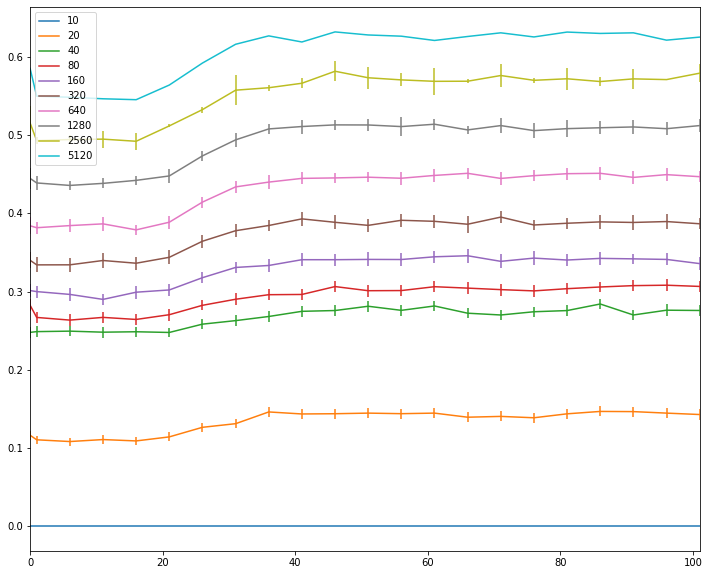

In [122]:
mean.plot(yerr=err, figsize=(12, 10))

In [92]:
assert tuple(test_outputs.keys()) == (None,)
cv_for_test_data, test_data = test_outputs[None]

a = {}
for name, dict_plottable in (("cv", cv_for_test_data), ("test", test_data)):
    plottable = pd.DataFrame(dict_plottable)
    mean, err = plottable_to_mean_err(plottable)
    mean = mean.sort_index()
    err = err.sort_index()
    a[name] = (mean, err)

pd.to_pickle(a, "~/Programacio/cnn-limits/figures/m10_test.pkl.gz")

In [93]:
a['test'][0]

,10,20,40,80,160,320,640,1280,2560
0,0.155416,0.167485,0.193381,0.235994,0.285281,0.340412,0.392625,0.45350,0.5138
1,0.155253,0.166685,0.183806,0.230428,0.281006,0.339862,0.392875,0.44780,0.5126
6,0.154566,0.171846,0.190761,0.232809,0.284894,0.334162,0.399500,0.45300,0.5126
11,0.155300,0.172400,0.191387,0.233237,0.273162,0.339850,0.395375,0.45370,0.5123
16,0.154887,0.175679,0.192609,0.232141,0.275944,0.338337,0.398075,0.44795,0.5153
21,0.156396,0.171639,0.197911,0.240447,0.281994,0.348962,0.399625,0.46845,0.5255
26,0.158098,0.175427,0.203558,0.248641,0.310800,0.362787,0.430525,0.49145,0.5526
31,0.159922,0.182293,0.211980,0.266178,0.327644,0.381700,0.453125,0.51250,0.5754
36,0.160564,0.187251,0.205391,0.268834,0.329081,0.387300,0.455325,0.52240,0.5836
41,0.163582,0.192188,0.215819,0.276147,0.324219,0.393312,0.458050,0.52550,0.5853


In [31]:
a['test'][0].loc[:, 2560]

0      0.5138
1      0.5126
2      0.5121
3      0.5116
4      0.5126
        ...  
97     0.5841
98     0.5833
99     0.5819
100    0.5853
101    0.5842
Name: 2560, Length: 102, dtype: float64